# Setup, Import Required Libraries and Load Data

In [1]:
# Install necessary packages
!pip install nltk scikit-learn imbalanced-learn matplotlib seaborn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import nltk
import string

# Download stopwords
nltk.download('stopwords')
nltk.download('wordnet')

# Load the new dataset
from google.colab import files
uploaded = files.upload()  # Upload your new dataset file here
new_df = pd.read_csv('spam_email.csv')  # Replace with actual file name

# Rename columns if needed
# Assuming the dataset has columns named 'Label' and 'text', rename as required
new_df.rename(columns={'Label': 'spam', 'text': 'text'}, inplace=True)

# Check dataset structure
print("Dataset Information:")
print(new_df.info())
print("First few rows:")
print(new_df.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Saving spam_email.csv to spam_email.csv
Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB
None
First few rows:
   label                                               text
0      1  ounce feather bowl hummingbird opec moment ala...
1      1  wulvob get your medircations online qnb ikud v...
2      0   computer connection from cnn com wednesday es...
3      1  university degree obtain a prosperous future m...
4      0  thanks for all your answers guys i know i shou...


# Preprocessing with Lemmatization

In [3]:
!pip install tqdm
from tqdm import tqdm


lemmatizer = WordNetLemmatizer()

# Wrap tqdm around the pandas apply function
tqdm.pandas()  # This enables tqdm to be used with Pandas

def clean_text(text):
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Tokenize and remove stopwords
    words = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    # Lemmatize words
    words = [lemmatizer.lemmatize(word.lower()) for word in words]
    return ' '.join(words)

# Apply preprocessing with progress bar
new_df['cleaned_text'] = new_df['text'].progress_apply(clean_text)


100%|██████████| 83448/83448 [35:57<00:00, 38.68it/s]


# Vectorization with TF-IDF (Including Bi-grams and Tri-grams)


In [8]:
# Rename the 'label' column to 'spam'
new_df.rename(columns={'label': 'spam'}, inplace=True)

# Check if renaming was successful
print("Updated column names:", new_df.columns)

# Proceed with vectorization and SMOTE
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(new_df['cleaned_text'])
y = new_df['spam']



Updated column names: Index(['spam', 'text', 'cleaned_text'], dtype='object')


# Handling Class Imbalance with SMOTE

In [9]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print("Original dataset shape:", y.value_counts())
print("Resampled dataset shape:", np.bincount(y_resampled))


Original dataset shape: spam
1    43910
0    39538
Name: count, dtype: int64
Resampled dataset shape: [43910 43910]


# Split Data and Train with Hyperparameter Tuning

In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Hyperparameter tuning with GridSearchCV
parameters = {'alpha': [0.1, 0.5, 1.0]}
nb_classifier = MultinomialNB()
grid_search = GridSearchCV(nb_classifier, parameters, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

# Train the model with the best parameters
best_nb = grid_search.best_estimator_
best_nb.fit(X_train, y_train)


Best Parameters: {'alpha': 0.1}


MultinomialNB(alpha=0.1)

# Evaluate the Model

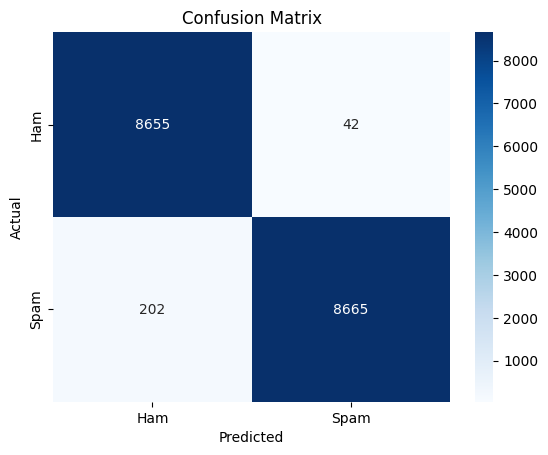

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8697
           1       1.00      0.98      0.99      8867

    accuracy                           0.99     17564
   macro avg       0.99      0.99      0.99     17564
weighted avg       0.99      0.99      0.99     17564



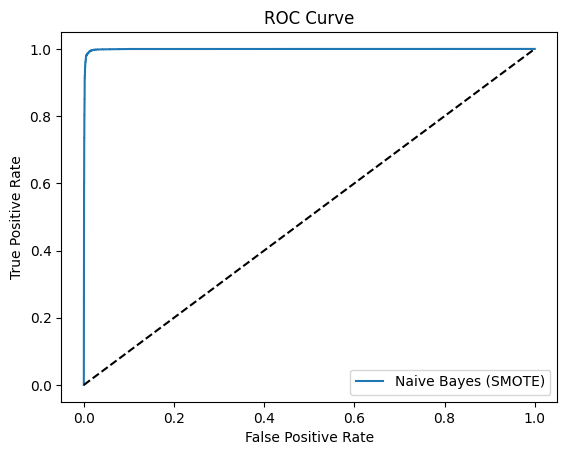

AUC Score: 0.9989268611036429


In [11]:
# Predictions
y_pred = best_nb.predict(X_test)
y_prob = best_nb.predict_proba(X_test)[:,1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='Naive Bayes (SMOTE)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Calculate AUC Score
auc_score = roc_auc_score(y_test, y_prob)
print("AUC Score:", auc_score)


# Validating Model through Sample Mail

In [12]:
def preprocess_email(email_text):
    # Remove punctuation
    email_text = ''.join([char for char in email_text if char not in string.punctuation])
    # Tokenize and remove stopwords
    words = [word for word in email_text.split() if word.lower() not in stopwords.words('english')]
    # Lemmatize words
    words = [lemmatizer.lemmatize(word.lower()) for word in words]
    return ' '.join(words)

def predict_spam(email_text, model, vectorizer):
    # Preprocess the email
    cleaned_text = preprocess_email(email_text)
    # Transform the email text using the TF-IDF vectorizer
    email_features = vectorizer.transform([cleaned_text])
    # Predict using the trained model
    prediction = model.predict(email_features)
    # Return the result
    return 'Spam' if prediction == 1 else 'Ham'

# Example email text to classify
sample_email = "Congratulations! You've won a free ticket to the Bahamas. Click here to claim your prize."

# Call the prediction function with the trained model and TF-IDF vectorizer
result = predict_spam(sample_email, best_nb, vectorizer)
print(f"The email is classified as: {result}")


The email is classified as: Spam
